In [13]:
from scipy.stats import ttest_ind, zscore, pearsonr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def cal_z_score(ground_truth, predictions):

    r, p = pearsonr(ground_truth, predictions)
    age_gap = predictions - ground_truth
    z_scored_age_gap = zscore(age_gap)
    return {
        "ground_truth": ground_truth,
        "prediction": predictions,
        "z_score":z_scored_age_gap,
        "r_value":r,
        "p_value":p,
        "rsquared": r2_score(ground_truth, predictions)
    }

def plot_age_gap(ground_truth, prediction, title="",save_path=None):
        z_scores = cal_z_score(ground_truth.values, prediction.values )
        df_z_scores = pd.DataFrame.from_dict(z_scores)
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df_z_scores, x="ground_truth", y="prediction", hue="z_score", palette='coolwarm', edgecolor='k', alpha=0.4, legend=False, lw=0)
        plt.plot([ground_truth.min(), ground_truth.max()], [ground_truth.min(), ground_truth.max()], 'k--', lw=2)
        norm = plt.Normalize(df_z_scores["z_score"].min(), df_z_scores["z_score"].max())
        sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
        sm.set_array([])
        plt.colorbar(sm, label='z-scored age gap')
        plt.xlabel('Chronological Age',fontsize=18)
        plt.ylabel('Predicted Age',fontsize=18)
        plt.title(f'{title}',fontsize=18)
        r = df_z_scores["r_value"].values[0]
        p = df_z_scores["p_value"].values[0]
        rsq = df_z_scores["rsquared"].values[0]
        plt.text(0.05, 0.95, f'Slope = 1\n$R^2$ = {rsq:.2f}\n$\\rho$ = {r:.2f}\np = {p:.2e}', 
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"))
        #plt.show()
        if save_path is not None: plt.savefig(save_path, dpi=300, bbox_inches='tight') 
        plt.show()

from scipy.stats import linregress

def plot_cell_age_gap(cell_type, ground_truth, predicted, save_path = None):
    plt.figure(figsize=(8, 6))
    correlation = cal_z_score(ground_truth, predicted)
    sns.regplot(
        x="ground_truth",
        y="prediction",
        data=correlation,
        ci=None,
        scatter_kws={"s": 20, "color": "blue"},
        line_kws={"color": "black"},
    )
    r = correlation["r_value"]
    p = correlation["p_value"]
    rsq = correlation["rsquared"]
    slope, intercept, _, _, _= linregress(x=predicted, y=ground_truth)
    plt.text(0.05, 0.95, f'Slope = {slope:.2f}\n$R^2$ = {rsq:.2f}\n$\\rho$ = {r:.2f}\np = {p:.2e}', 
            transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"))
    formatted_title = cell_type.replace("-positive", "+").replace("alpha-beta", "")
    plt.title(f"{' '.join([t.capitalize() for t in formatted_title.split(' ')])} (N = {len(ground_truth)})", fontsize=16)
    plt.xlabel("Chronological Age")
    plt.ylabel("Predicted Age")
    
    if save_path is not None: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [3]:
import os
import scanpy as sc

path = '/media/lleger/LaCie/age_cage/'
adatas = [sc.read_h5ad(os.path.join(path, f)).obs for f in os.listdir(path) if 'phenotype' in f and f.endswith('.h5ad')]
test_chunk = pd.concat(adatas)

(100000, 29)


/tmp/ipykernel_1833258/3384773030.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


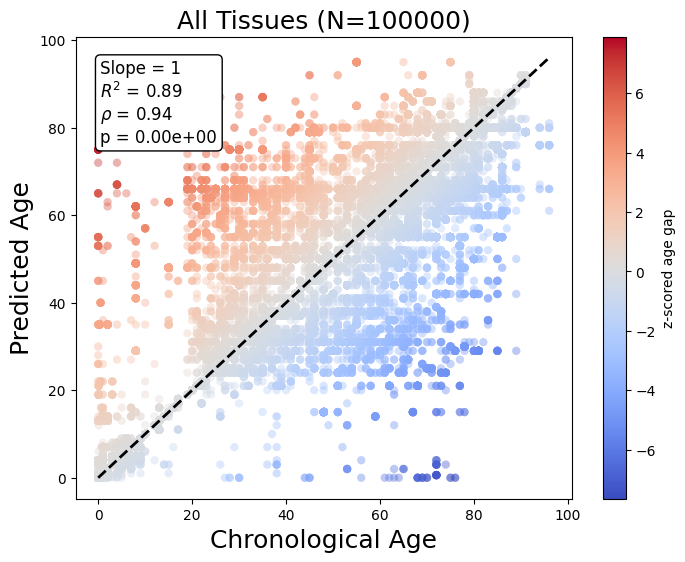

(1625, 29)


/tmp/ipykernel_1833258/3384773030.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


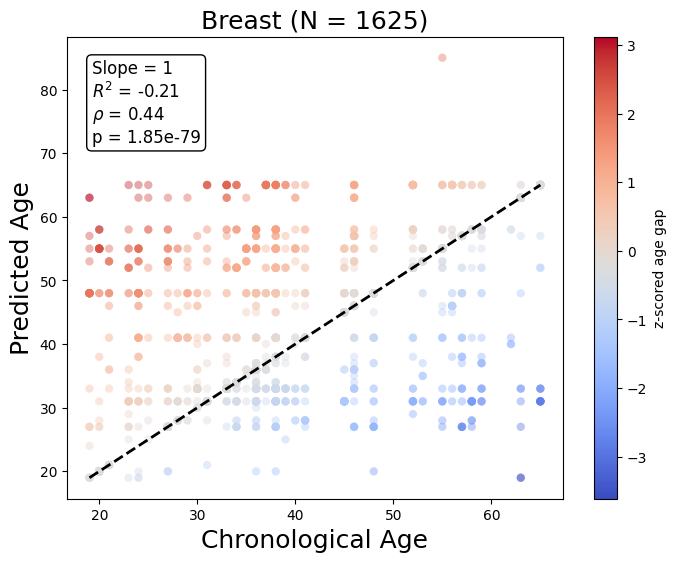

(1094, 29)


/tmp/ipykernel_1833258/3384773030.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


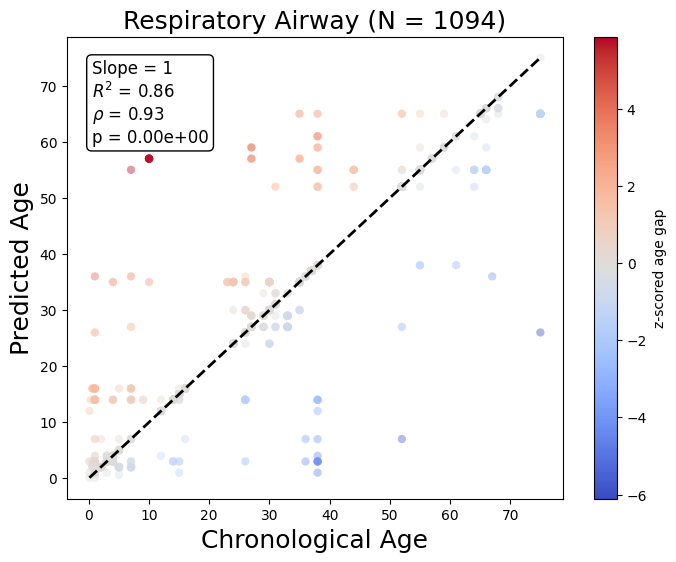

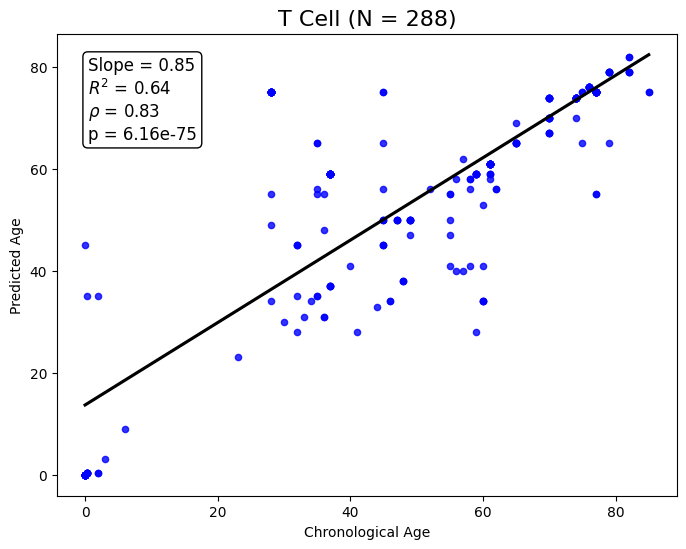

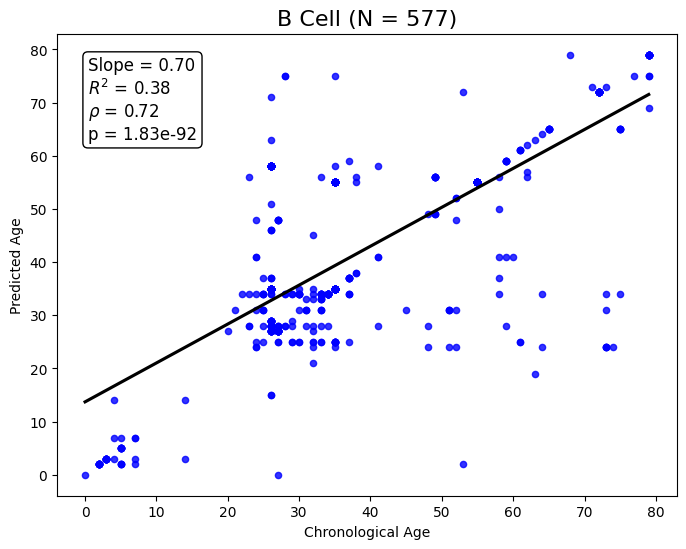

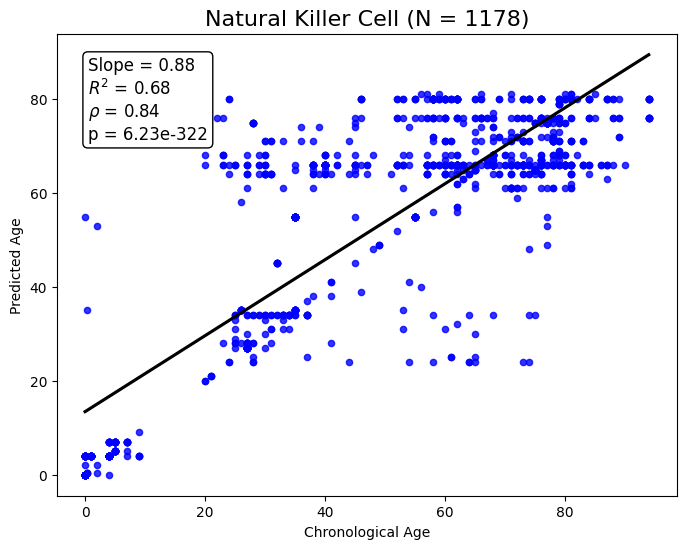

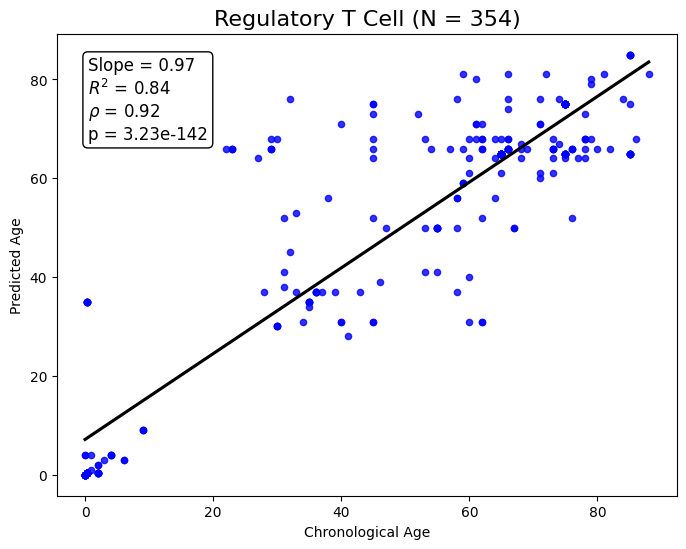

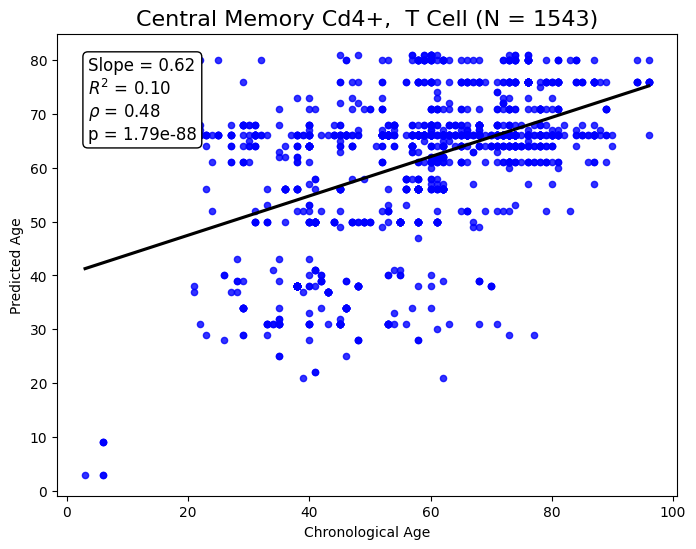

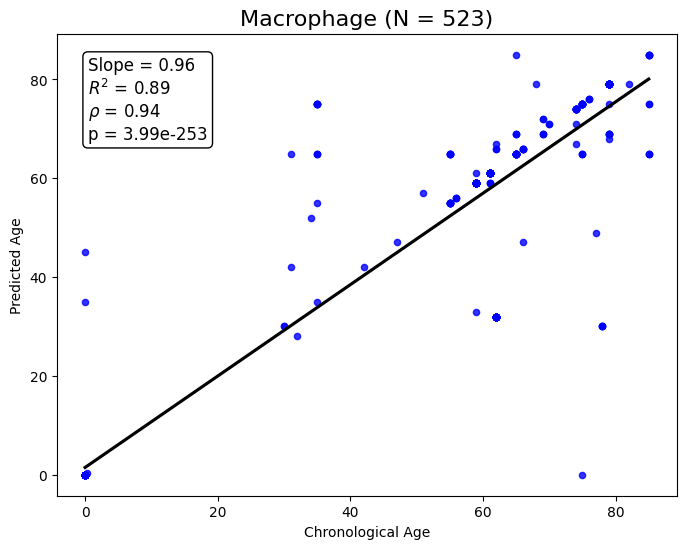

In [14]:
healthy = test_chunk.dropna(subset=['age', 'age_pred'])[:int(1e5)]#[test_chunk['disease'] == 'normal']
print(healthy.shape)
plot_age_gap(healthy['age'], healthy['age_pred'], title=f"All Tissues (N={len(healthy)})", save_path="age_gap_line.png")
tissues = ['breast', "respiratory airway"]
for tissue in tissues: 
    healthy = test_chunk[(test_chunk['disease'] == 'normal') & (test_chunk["tissue"] == tissue)].dropna(subset=['age', 'age_pred'])
    print(healthy.shape)
    plot_age_gap(healthy['age'], healthy['age_pred'], title=f"{' '.join([t.capitalize() for t in tissue.split(' ')])} (N = {len(healthy)})", save_path=f'{tissue}_age_gap.png')

ref_cell_types = ['T cell', 'B cell', 'natural killer cell', 'regulatory T cell', 'central memory CD4-positive, alpha-beta T cell', 'macrophage']
for cell_type in ref_cell_types:
    healthy = test_chunk[(test_chunk['disease'] == 'normal') & (test_chunk["cell_type"] == cell_type)].dropna(subset=['age', 'age_pred'])
    plot_cell_age_gap(cell_type, healthy['age'], healthy['age_pred'], save_path=f'{cell_type}_age_gap.png')